<a href="https://colab.research.google.com/github/pedrohortencio/machine-learning-gladiator/blob/main/Wine%20Quality/Wine_Quality_Gladiator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing packages

In [64]:
import numpy as np                  
import pandas as pd                 
import matplotlib.pyplot as plt     
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras

from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


grid = False

seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

sns.set_theme()
%matplotlib inline

###Downloading the competition data

In [2]:
# Changing the directory of kaggle.json token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

#Downloading the dataset
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009

# Using only the red wine data, which is around 25% of the whole dataset

kaggle.json
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 20.4MB/s]


###Creating dataframes

In [119]:
df = pd.read_csv('/content/red-wine-quality-cortez-et-al-2009.zip', header=0, sep=',', 
                       quotechar='"')

In [120]:
df.sample(7)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
349,9.1,0.785,0.00,2.6,0.093,11.0,28.0,0.99940,3.36,0.86,9.4,6
245,7.3,0.660,0.00,2.0,0.084,6.0,23.0,0.99830,3.61,0.96,9.9,6
546,7.5,0.550,0.24,2.0,0.078,10.0,28.0,0.99830,3.45,0.78,9.5,6
315,7.1,0.350,0.29,2.5,0.096,20.0,53.0,0.99620,3.42,0.65,11.0,6
82,7.4,0.500,0.47,2.0,0.086,21.0,73.0,0.99700,3.36,0.57,9.1,5
898,8.3,0.310,0.39,2.4,0.078,17.0,43.0,0.99444,3.31,0.77,12.5,7
761,9.3,0.655,0.26,2.0,0.096,5.0,35.0,0.99738,3.25,0.42,9.6,5


In [135]:
print("Dataset shape:", df.shape)

Dataset shape: (1359, 12)


In [123]:
duplicate_rows_df = df[df.duplicated()]
print(" number of duplicate rows: ", duplicate_rows_df.shape )

 number of duplicate rows:  (240, 12)


In [125]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


In [126]:
# Counting missing values
df.isnull().sum().sort_values(ascending=False)

quality                 0
alcohol                 0
sulphates               0
pH                      0
density                 0
total sulfur dioxide    0
free sulfur dioxide     0
chlorides               0
residual sugar          0
citric acid             0
volatile acidity        0
fixed acidity           0
dtype: int64

In [127]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

In [128]:
# 1 = good (the quality is at least 7)
# 0 = bad (the quality is bellow 7)
df['quality'] = [1 if i>=7 else 0 for i in df['quality']]

In [136]:
print("Dataset shape:", df.shape)

Dataset shape: (1359, 12)


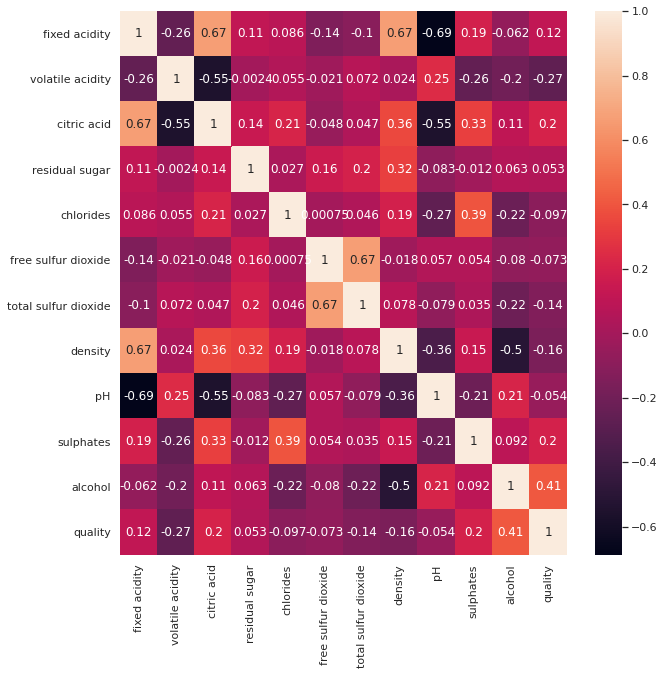

In [129]:
#Analysing the correlation of features 

mat = df.corr()
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(mat, annot = True, annot_kws={'size': 12});

###Creating dataframes with normalized values

In [130]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm.iloc[:,0:-1] = scaler.fit_transform(df.iloc[:,0:-1].to_numpy())

In [131]:
df_norm.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.524431,0.932000,-1.393258,-0.461157,-0.245623,-0.468554,-0.384050,0.584003,1.291872,-0.578561,-0.954374,0
1,-0.294063,1.915800,-1.393258,0.056665,0.200094,0.872003,0.604073,0.048737,-0.708395,0.124822,-0.584575,0
2,-0.294063,1.259934,-1.188617,-0.165259,0.078535,-0.085537,0.214813,0.155790,-0.321247,-0.051024,-0.584575,0


###Splitting the data

In [132]:
# Creating the ndarrays from the training dataset
y = df['quality'].to_numpy()
X = df.drop('quality', axis=1).to_numpy()

y_norm = df_norm['quality'].to_numpy()
X_norm = df_norm.drop('quality', axis=1).to_numpy()

In [133]:
# Creating the train and validation datasets
(X_train, X_validation, 
 y_train, y_validation) = train_test_split(X, y, test_size = 0.2, random_state=0)

(X_train_norm, X_validation_norm, 
 y_train_norm, y_validation_norm) = train_test_split(X_norm, y_norm, test_size = 0.2, random_state=0)

In [134]:
print('Unnormalized datasets')
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print()
print('Normalized datasets')
print('Train', X_train_norm.shape)
print('Validation', X_validation_norm.shape)

Unnormalized datasets
(1087, 11)
(1087,)
(272, 11)
(272,)

Normalized datasets
Train (1087, 11)
Validation (272, 11)


## Creating Models
(with the unnormalized dataset)

In [138]:
# 5 layers with dropout and regularization (both L1 and L2)
def create_model():
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation=tf.nn.relu),

                                        tf.keras.layers.Dense(64, activation=tf.nn.relu),

                                        tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                        
                                        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
    model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [146]:
# Function that creates and trains all models. It will make it easier to train twice (with non-normalized and normalized data)

def train_models(X_train, y_train, X_validation, y_validation, print_acc=False):

    dict_acc = {}

    ### Dummy Classifier
    dummy = DummyClassifier(strategy='prior')
    
    scores = cross_val_score(dummy, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_dummy_train = scores.mean()
    dummy.fit(X_train, y_train)
    acc_dummy_val = dummy.score(X_validation, y_validation)

    dict_acc['Dummy Classifier'] = [acc_dummy_train, acc_dummy_val]


    ### Bernoulli Naive Bayes
    bernoulli = BernoulliNB(alpha=1)

    scores = cross_val_score(bernoulli, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_bernoulli_train = scores.mean()
    bernoulli.fit(X_train, y_train)
    acc_bernoulli_val = bernoulli.score(X_validation, y_validation)

    dict_acc['Bernoulli NB'] = [acc_bernoulli_train, acc_bernoulli_val]


    ### K-Nearest Neighbors
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors = 10, weights='distance')


    scores = cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_knn_train = scores.mean()
    knn.fit(X_train, y_train)
    acc_knn_val = knn.score(X_validation, y_validation)

    dict_acc['KNN'] = [acc_knn_train, acc_knn_val]


    ### SGD Classifier
    sgd = SGDClassifier(alpha=0.01, epsilon = 0.3, loss='modified_huber', max_iter=5000, penalty='l1')

    scores = cross_val_score(sgd, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_sgd_train = scores.mean()
    sgd.fit(X_train, y_train)
    acc_sgd_val = sgd.score(X_validation, y_validation)

    dict_acc['SGD'] = [acc_sgd_train, acc_sgd_val]

    ### Logistic Regression
    logreg = LogisticRegression(C=0.5, max_iter = 2000, penalty='l1', solver='liblinear')

    scores = cross_val_score(logreg, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_logreg_train = scores.mean()
    logreg.fit(X_train, y_train)
    acc_logreg_val = logreg.score(X_validation, y_validation)

    dict_acc['Logistic Regression'] = [acc_logreg_train, acc_logreg_val]


    ### Ridge Classifier
    ridge = RidgeClassifier(alpha=1, solver='auto')

    scores = cross_val_score(ridge, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_ridge_train = scores.mean()
    ridge.fit(X_train, y_train)
    acc_ridge_val = ridge.score(X_validation, y_validation)
    
    dict_acc['Ridge Classifier'] = [acc_ridge_train, acc_ridge_val]


    ### Support Vector Classifier
    svc = SVC(C=3, kernel='rbf', decision_function_shape='ovo')

    scores = cross_val_score(svc, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_svc_train = scores.mean()
    svc.fit(X_train, y_train)
    acc_svc_val = svc.score(X_validation, y_validation)

    dict_acc['SVC'] = [acc_svc_train, acc_svc_val]


    ### Decision Tree
    tree = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=3)

    scores = cross_val_score(tree, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_tree_train = scores.mean()
    tree.fit(X_train, y_train)
    acc_tree_val = tree.score(X_validation, y_validation)

    dict_acc['Decision Tree'] = [acc_tree_train, acc_tree_val]


    ### Random Forest
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=3, min_samples_split=3)

    scores = cross_val_score(rf, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_rf_train = scores.mean()
    rf.fit(X_train, y_train)
    acc_rf_val = rf.score(X_validation, y_validation)

    dict_acc['Random Forest'] = [acc_rf_train, acc_rf_val]


    ### XGBoost Classifier
    xgboost = XGBClassifier(eta=0.1, max_depth=4)

    scores = cross_val_score(xgboost, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_xgboost_train = scores.mean()
    xgboost.fit(X_train, y_train)
    acc_xgboost_val = xgboost.score(X_validation, y_validation)

    dict_acc['XGBoost'] = [acc_xgboost_train, acc_xgboost_val]


    ### Neural Network (Keras)
    model_keras = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)

    results = cross_val_score(model_keras, X_train, y_train, cv=kfold)
    acc_train = results.mean()
    model_keras.fit(X_train, y_train)
    acc_keras = model_keras.score(X_validation, y_validation)

    dict_acc['DNN'] = [acc_train, acc_keras] 

    # Printing the values
    if print_acc:
        for key, values in dict_acc.items():
            print("{} Accuracy on Training Data (CV): {}".format(key, values[0]))
            print("{} Accuracy on Validation Data: {}".format(key, values[1]))
            print()
    
    return dict_acc

## Grid Search

In [ ]:
if grid:
    ###Naive Bayes (Bernoulli)
    parameter = [{'alpha':[1.0, 5, 10, 15, 20]}]
    classifier = GridSearchCV(BernoulliNB(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("Bernoulli")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'alpha': 1.0}

    ###KNN
    parameter = [{'n_neighbors':[2, 3, 5, 7, 10],
                'weights':['uniform', 'distance'],
                'metric':['minkowski', 'manhattan']}]

    classifier = GridSearchCV(KNeighborsClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("KNN")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

    ###SGD
    parameter = [{'loss':['hinge', 'modified_huber', 'perceptron', 'huber', 'epsilon_insensitive'],
                'penalty':['l1', 'l2'],
                'alpha':[0.001, 0.01, 0.1],
                'epsilon':[0.01, 0.1, 0.3, 0.5],
                'max_iter':[5000]}]

    classifier = GridSearchCV(SGDClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train_norm, y_train_norm)
    print("SGD")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'alpha': 0.01, 'epsilon': 0.3, 'loss': 'modified_huber', 'max_iter': 5000, 'penalty': 'l1'}

    ###Logistic Regression
    parameter = [{'penalty':['l1', 'l2'],
                'C':[1.0, 0.5, 1.5, 2, 3, 5],
                'solver':['lbfgs', 'liblinear', 'sag', 'saga'],
                'max_iter':[2000]}]

    classifier = GridSearchCV(LogisticRegression(), parameter, scoring='accuracy')
    classifier.fit(X_train_norm, y_train_norm)
    print("Logistic Regression")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'C': 0.5, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


    ###Ridge Classifier
    parameter = [{'alpha':[1.0, 0.5, 3, 5, 7, 10],
                'solver':['auto', 'sag', 'saga', 'svd']}]

    classifier = GridSearchCV(RidgeClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("Ridge Classifier")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'alpha': 1.0, 'solver': 'auto'}


    ###SVC
    parameter = [{'C':[0.5, 1.0, 3, 5],
                'kernel':['linear', 'rbf']}]

    classifier = GridSearchCV(SVC(), parameter, scoring='accuracy')
    classifier.fit(X_train_norm, y_train_norm)
    print("SVC")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'C': 3, 'kernel': 'rbf'}

    ###Decision Tree
    parameter = [{'criterion':['gini', 'entropy'],
                'min_samples_split':[2, 3, 4, 5],
                'min_samples_leaf':[1, 4, 5]}]

    classifier = GridSearchCV(DecisionTreeClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("Decision Tree")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 3}

    ###Random Forest
    parameter = [{'criterion':['gini', 'entropy'],
              'n_estimators':[100, 300],
              'min_samples_split':[3, 4, 5],
              'min_samples_leaf':[3, 5, 10]}]

    classifier = GridSearchCV(RandomForestClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("Random Forest")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}

    ###XGBoost
    parameter = [{'eta':[0.1, 0.3, 0.5, 1],
                'max_depth':[4, 6, 8, 10]}]

    classifier = GridSearchCV(XGBClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("XGBoost")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'eta': 0.1, 'max_depth': 4}

##Plotting

In [147]:
dict_models = train_models(X_train, y_train, X_validation, y_validation, print_acc=True)

Dummy Classifier Accuracy on Training Data (CV): 0.8675263180146283
Dummy Classifier Accuracy on Validation Data: 0.8529411764705882

Bernoulli NB Accuracy on Training Data (CV): 0.8675263180146283
Bernoulli NB Accuracy on Validation Data: 0.8529411764705882

KNN Accuracy on Training Data (CV): 0.8711960427852704
KNN Accuracy on Validation Data: 0.8639705882352942

SGD Accuracy on Training Data (CV): 0.8565002325286433
SGD Accuracy on Validation Data: 0.8308823529411765

Logistic Regression Accuracy on Training Data (CV): 0.8776349723079525
Logistic Regression Accuracy on Validation Data: 0.8419117647058824

Ridge Classifier Accuracy on Training Data (CV): 0.8776476556884962
Ridge Classifier Accuracy on Validation Data: 0.8308823529411765

SVC Accuracy on Training Data (CV): 0.8675263180146283
SVC Accuracy on Validation Data: 0.8529411764705882

Decision Tree Accuracy on Training Data (CV): 0.8702743837990953
Decision Tree Accuracy on Validation Data: 0.8051470588235294

Random Forest 

In [148]:
df_acc = pd.DataFrame.from_dict(dict_models)
df_acc = df_acc.transpose()
df_acc.columns = ['Acc Training (CV)', 'Acc Validation']
df_acc

,Acc Training (CV),Acc Validation
Dummy Classifier,0.867526,0.852941
Bernoulli NB,0.867526,0.852941
KNN,0.871196,0.863971
SGD,0.856500,0.830882
Logistic Regression,0.877635,0.841912
Ridge Classifier,0.877648,0.830882
SVC,0.867526,0.852941
Decision Tree,0.870274,0.805147
Random Forest,0.896055,0.830882
XGBoost,0.896055,0.816176


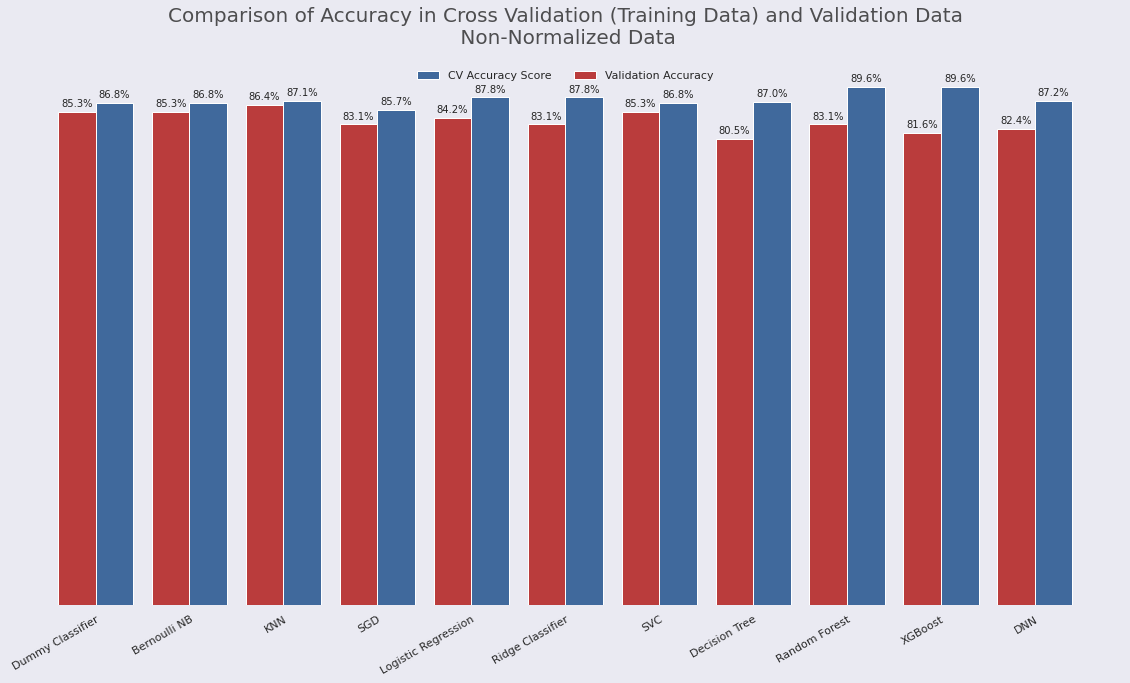

In [149]:
fig = plt.figure(figsize=(20,10))   # changes the size of the image
fig.patch.set_facecolor('#eaeaf2')  # set the background color of the plot to match the seaborn theme

ax = plt.gca()
width = 0.40

rects1 = ax.bar(df_acc.index, df_acc['Acc Training (CV)'], width,align='edge', color = '#40699c', label='CV Accuracy Score')
rects2 = ax.bar(df_acc.index, df_acc['Acc Validation'], -width, align='edge', color = '#ba3c3c', label='Validation Accuracy')

for r1, r2 in zip(rects1.patches, rects2.patches):
    h1 = r1.get_height()
    h2 = r2.get_height()

    percent1 = h1*100
    percent2 = h2*100

    ax.annotate('{:.1f}%'.format(percent1),
                    xy=(r1.get_x() + r1.get_width() / 2, h1),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.annotate('{:.1f}%'.format(percent2),
                    xy=(r2.get_x() + r2.get_width() / 2, h2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Rotate the X labels (models' names)

plt.box(False)  # disable the box around the plot
ax.grid(False)  # disable the grid
ax.set_yticks([])   # disable the y ticks
plt.xticks(rotation=30, rotation_mode="anchor", ha='right')

# creating a title
plt.title('Comparison of Accuracy in Cross Validation (Training Data) and Validation Data\n Non-Normalized Data',
          size=20, alpha=0.8, y=1.02)

# add the legend (to display the horizontal lines' labels)
plt.legend(frameon=False, loc='upper center', ncol=2)

# saves the plot
plt.savefig("accuracy-nonnormalized.png", bbox_inches='tight', dpi=300)
# displays the plot
plt.show();

###Normalized Data

In [150]:
dict_models_norm = train_models(X_train_norm, y_train_norm, X_validation_norm, y_validation_norm)

In [151]:
df_acc_norm = pd.DataFrame.from_dict(dict_models_norm)
df_acc_norm = df_acc_norm.transpose()
df_acc_norm.columns = ['Acc Training (CV)', 'Acc Validation']
df_acc_norm

,Acc Training (CV),Acc Validation
Dummy Classifier,0.867526,0.852941
Bernoulli NB,0.854644,0.816176
KNN,0.884099,0.834559
SGD,0.888686,0.816176
Logistic Regression,0.893286,0.819853
Ridge Classifier,0.875804,0.838235
SVC,0.883169,0.834559
Decision Tree,0.873035,0.808824
Random Forest,0.893295,0.812500
XGBoost,0.896055,0.816176


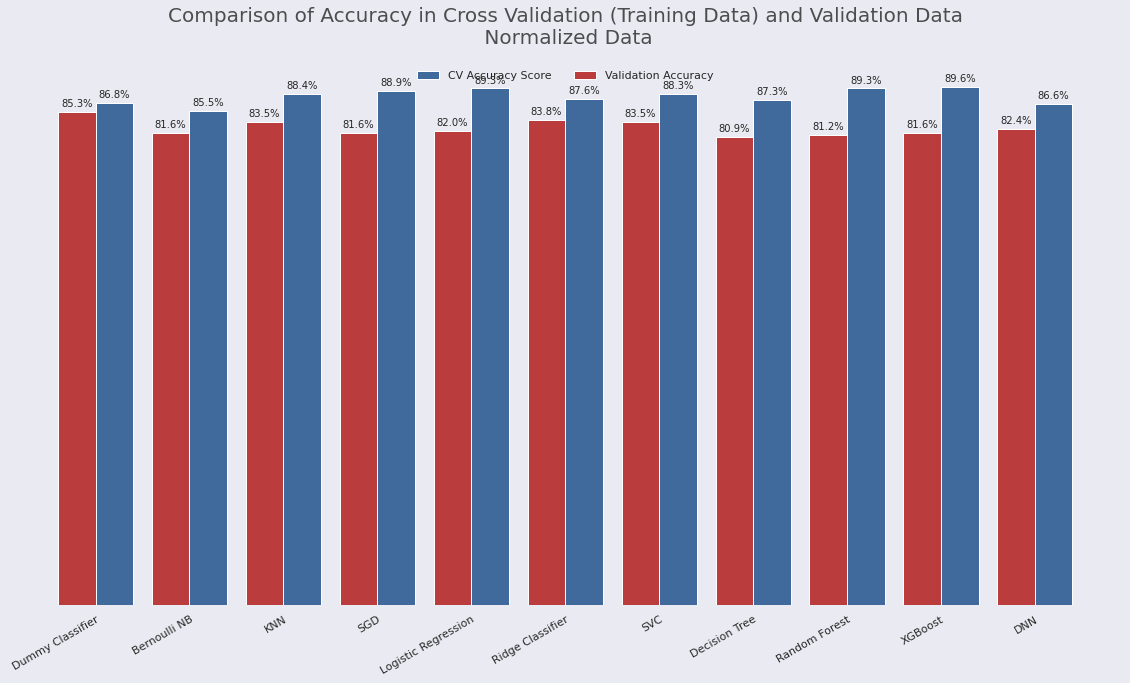

In [152]:
fig = plt.figure(figsize=(20,10))   # changes the size of the image
fig.patch.set_facecolor('#eaeaf2')  # set the background color of the plot to match the seaborn theme

ax = plt.gca()
width = 0.40

rects1 = ax.bar(df_acc_norm.index, df_acc_norm['Acc Training (CV)'], width,align='edge', color = '#40699c', label='CV Accuracy Score')
rects2 = ax.bar(df_acc_norm.index, df_acc_norm['Acc Validation'], -width, align='edge', color = '#ba3c3c', label='Validation Accuracy')

for r1, r2 in zip(rects1.patches, rects2.patches):
    h1 = r1.get_height()
    h2 = r2.get_height()

    percent1 = h1*100
    percent2 = h2*100

    ax.annotate('{:.1f}%'.format(percent1),
                    xy=(r1.get_x() + r1.get_width() / 2, h1),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.annotate('{:.1f}%'.format(percent2),
                    xy=(r2.get_x() + r2.get_width() / 2, h2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Rotate the X labels (models' names)

plt.box(False)  # disable the box around the plot
ax.grid(False)  # disable the grid
ax.set_yticks([])   # disable the y ticks
plt.xticks(rotation=30, rotation_mode="anchor", ha='right')

# creating a title
plt.title('Comparison of Accuracy in Cross Validation (Training Data) and Validation Data\n Normalized Data',
          size=20, alpha=0.8, y=1.02)

# add the legend (to display the horizontal lines' labels)
plt.legend(frameon=False, loc='upper center', ncol=2)

# saves the plot
plt.savefig("accuracy-normalized.png", bbox_inches='tight', dpi=300)
# displays the plot
plt.show();

### Comparison Between Normalized and Non-Normalized Accuracy

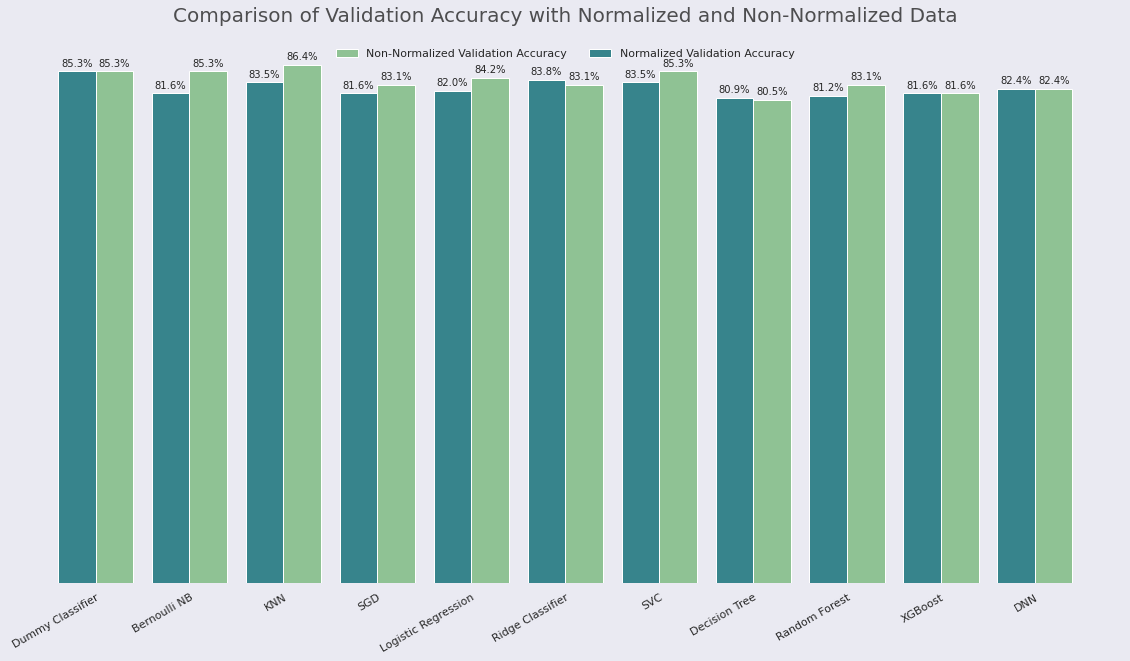

In [153]:
fig = plt.figure(figsize=(20,10))   # changes the size of the image
fig.patch.set_facecolor('#eaeaf2')  # set the background color of the plot to match the seaborn theme

ax = plt.gca()
width = 0.40

rects1 = ax.bar(df_acc.index, df_acc['Acc Validation'], width,align='edge', color = '#8FC294', label='Non-Normalized Validation Accuracy')
rects2 = ax.bar(df_acc_norm.index, df_acc_norm['Acc Validation'], -width, align='edge', color = '#37848C', label='Normalized Validation Accuracy')

for r1, r2 in zip(rects1.patches, rects2.patches):
    h1 = r1.get_height()
    h2 = r2.get_height()

    percent1 = h1*100
    percent2 = h2*100

    ax.annotate('{:.1f}%'.format(percent1),
                    xy=(r1.get_x() + r1.get_width() / 2, h1),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.annotate('{:.1f}%'.format(percent2),
                    xy=(r2.get_x() + r2.get_width() / 2, h2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Rotate the X labels (models' names)

plt.box(False)  # disable the box around the plot
ax.grid(False)  # disable the grid
ax.set_yticks([])   # disable the y ticks
plt.xticks(rotation=30, rotation_mode="anchor", ha='right')

# creating a title
plt.title('Comparison of Validation Accuracy with Normalized and Non-Normalized Data',
          size=20, alpha=0.8, y=1.02)

# add the legend (to display the horizontal lines' labels)
plt.legend(frameon=False, loc='upper center', ncol=2)

# saves the plot
plt.savefig("comparison-normalized-nonnormalized.png", bbox_inches='tight', dpi=300)
# displays the plot
plt.show();